
?? Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60882 entries, 0 to 60881
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   circuit_name            60882 non-null  object 
 1   node                    60882 non-null  object 
 2   gate_type               60882 non-null  object 
 3   fan_in                  60882 non-null  int64  
 4   fan_out                 60882 non-null  int64  
 5   depth                   60882 non-null  object 
 6   dist_to_output          60882 non-null  int64  
 7   is_primary_input        60882 non-null  int64  
 8   is_primary_output       60882 non-null  int64  
 9   is_internal             60882 non-null  int64  
 10  is_key_gate             60882 non-null  int64  
 11  key_dependency          122 non-null    object 
 12  degree_centrality       60882 non-null  float64
 13  betweenness_centrality  60882 non-null  float64
 14  closeness_centra

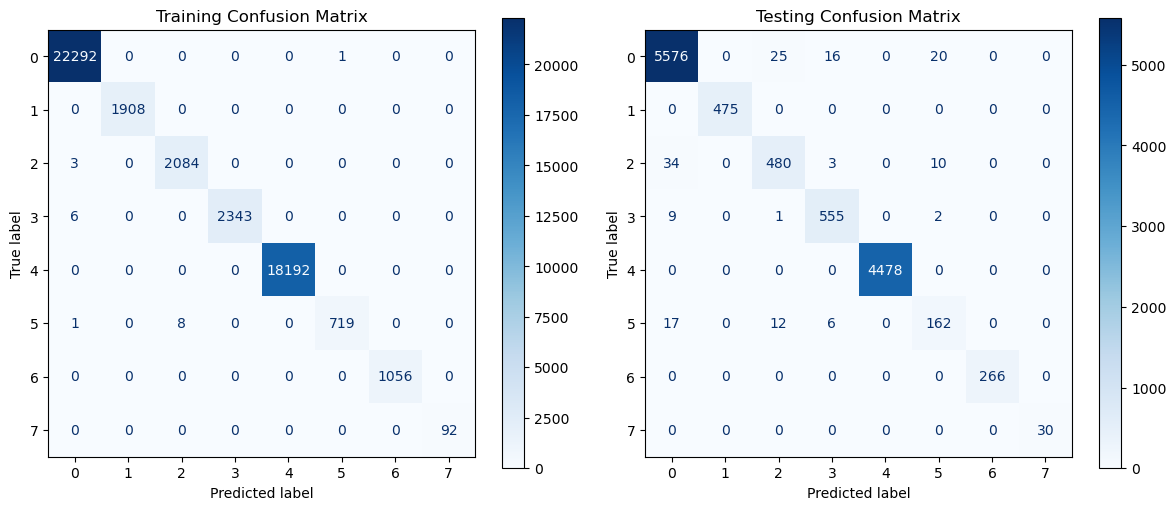

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, hamming

import torch
import torch.nn as nn
import torch.optim as optim

#############################################
# Part A: Load and Preprocess the Dataset
#############################################
df = pd.read_csv("all_circuits_features.csv")

print("\n?? Dataset Overview:")
print(df.info())

# Convert 'gate_type' to numerical labels.
label_encoder = LabelEncoder()
df["gate_label"] = label_encoder.fit_transform(df["gate_type"])

# Define feature columns (exactly as provided).
feature_columns = [
    "fan_in", "fan_out", "dist_to_output", "is_primary_input", "is_primary_output",
    "is_internal", "is_key_gate", "degree_centrality", "betweenness_centrality",
    "closeness_centrality", "clustering_coefficient", "avg_fan_in_neighbors", "avg_fan_out_neighbors"
]

# Drop rows with missing values.
df = df.dropna(subset=feature_columns)

# Convert features to float.
df[feature_columns] = df[feature_columns].astype(float)

# Normalize features.
scaler = StandardScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# Extract features and labels.
features = df[feature_columns].values    # shape: (num_nodes, num_features)
labels = df["gate_label"].values           # shape: (num_nodes,)
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

#############################################
# Part B: Train-Test Split
#############################################
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
print("\nTraining shape:", X_train.shape, "| Testing shape:", X_test.shape)


#############################################
# Part C: Decision Tree Training and Evaluation
#############################################
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predictions
train_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

# Accuracy
train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

print("\n?? Decision Tree Classification Results:")
print(f"  ? Training Accuracy: {train_acc:.4f}")
print(f"  ? Testing Accuracy:  {test_acc:.4f}")

#############################################
# Part D: Confusion Matrix Display
#############################################
train_cm = confusion_matrix(y_train, train_preds)
test_cm  = confusion_matrix(y_test, test_preds)

print("\nTraining Confusion Matrix:")
print(train_cm)
print("\nTesting Confusion Matrix:")
print(test_cm)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=np.unique(y_train))
disp_train.plot(cmap="Blues", ax=plt.gca(), values_format="d")
plt.title("Training Confusion Matrix")

plt.subplot(1,2,2)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=np.unique(y_test))
disp_test.plot(cmap="Blues", ax=plt.gca(), values_format="d")
plt.title("Testing Confusion Matrix")
plt.tight_layout()
plt.show()


In [2]:

#############################################
# Part E: Membership Inference Attack
#############################################
def evaluate_membership_decision_tree(features, labels, model, metric="cosine"):
    """
    Compute membership scores using model prediction probabilities
    and compare against one-hot true labels.
    """
    probs = model.predict_proba(features)
    scores = []
    for i in range(len(features)):
        target_class = labels[i]
        target_vec = np.zeros(probs.shape[1])
        target_vec[target_class] = 1.0  # One-hot encoding

        pred_vec = probs[i]

        if metric == "cosine":
            score = cosine_similarity(pred_vec.reshape(1, -1), target_vec.reshape(1, -1))[0][0]
        else:
            raise ValueError("Unsupported metric")
        scores.append(score)
    return np.array(scores)

# Calculate membership scores
train_score_cos = evaluate_membership_decision_tree(X_train, y_train, clf, metric="cosine")
test_score_cos  = evaluate_membership_decision_tree(X_test, y_test, clf, metric="cosine")

print("\nMembership Inference Score Averages (Decision Tree):")
print(f"  ? Cosine Similarity:  Training = {np.mean(train_score_cos):.4f}, Testing = {np.mean(test_score_cos):.4f}")

# Set thresholds (using mean of training scores)
delta_cos = 0.02
thr_cos = np.mean(train_score_cos) + delta_cos

# Infer membership
train_membership_cos = train_score_cos > thr_cos
test_membership_cos  = test_score_cos > thr_cos

# Display Membership Inference Results
print("\nMembership Inference Decision Outcomes (Cosine Metric):")
print(f"  ? Fraction of Training Samples inferred as Members: {np.mean(train_membership_cos):.2f}")
print(f"  ? Fraction of Testing Samples inferred as Non-Members: {np.mean(~test_membership_cos):.2f}")



Membership Inference Score Averages (Decision Tree):
  ? Cosine Similarity:  Training = 0.9997, Testing = 0.9874

Membership Inference Decision Outcomes (Cosine Metric):
  ? Fraction of Training Samples inferred as Members: 0.00
  ? Fraction of Testing Samples inferred as Non-Members: 1.00
